# Final project : Himalaya Expeditions

<h2>Table of Contents<span class="tocSkip"></span></h2>
<div class="toc">
    <ul>
        <li><span><a href="#Import-Library" data-toc-modified-id="Import-Library-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Library</a></span></li>
        <li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li>
        <li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Cleaning</a></span></li>
        <li><span><a href="#Call-APIs" data-toc-modified-id="Call-APIs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Call APIs</a></span></li>
        <li><span><a href="#Web-scraping" data-toc-modified-id="Web-scraping-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Web scraping</a></span></li>
        <li><span><a href="#Connection-to-SQL" data-toc-modified-id="Connection-to-SQL-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Connection to SQL</a></span></li>
        <li><span><a href="#Connection-to-Big-Query" data-toc-modified-id="Connection-to-Big-Query-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Connection to Big Query</a></span></li>
        <li><span><a href="#EDA" data-toc-modified-id="EDA-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>EDA</a></span></li>
        <li><span><a href="#Machine Learning" data-toc-modified-id="Machine Learning-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Machine Learning</a></span></li>
    </ul>
</div>

# 1 - Import Library : 

In [48]:
#installation : 
#pip install geopy
#pip install pyarrow pandas-gbq

import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time
import requests
from sqlalchemy import create_engine, text 
import os
from google.cloud import bigquery
import urllib.parse
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
import scipy.stats as st
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, r2_score, f1_score, precision_score,recall_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import joblib


# 2 - Load Data :

In [49]:
expedition_df = pd.read_csv('csv/expeditions.csv')
members_df = pd.read_csv('csv/members.csv')
peaks_df = pd.read_csv('csv/peaks.csv')
gps_df = pd.read_csv('csv/peak_gps.csv') # GPS coordinates from API


# 3 - Data cleaning : 

In [50]:
#shape : 
print (f'expedition : {expedition_df.shape}')
print (f'members : {members_df.shape}')
print (f'peaks : {peaks_df.shape}')


expedition : (10364, 16)
members : (76519, 21)
peaks : (468, 8)


In [51]:
#null values : 
print (f'expedition : {expedition_df.isnull().sum()}')
print (f'members : {members_df.isnull().sum()}')
print (f'peaks : {peaks_df.isnull().sum()}')

expedition : expedition_id            0
peak_id                  0
peak_name                1
year                     0
season                   0
basecamp_date         1095
highpoint_date         650
termination_date      2380
termination_reason       0
highpoint_metres       414
members                  0
member_deaths            0
hired_staff              0
hired_staff_deaths       0
oxygen_used              0
trekking_agency       1710
dtype: int64
members : expedition_id               0
member_id                   0
peak_id                     0
peak_name                  15
year                        0
season                      0
sex                         2
age                      3497
citizenship                10
expedition_role            21
hired                       0
highpoint_metres        21833
success                     0
solo                        0
oxygen_used                 0
died                        0
death_cause             75413
death_height_metres   

In [52]:
#check duplicated rows : 
print (f'expedition : {expedition_df.duplicated().sum()}')
print (f'peaks : {peaks_df.duplicated().sum()}')
print (f'members : {members_df.duplicated().sum()}')

expedition : 0
peaks : 0
members : 0


In [53]:
# df_expedition : formatting datetime, add is_sucess column : 
expedition_df['basecamp_date'] = pd.to_datetime(expedition_df['basecamp_date'], errors='coerce')
expedition_df['highpoint_date'] = pd.to_datetime(expedition_df['highpoint_date'], errors='coerce')
expedition_df['termination_date'] = pd.to_datetime(expedition_df['termination_date'], errors='coerce')
expedition_df['is_success'] = expedition_df['termination_reason'].apply(lambda x: True if x == 'Success (main peak)' else False)
print(expedition_df.dtypes)
expedition_df.head()


expedition_id                 object
peak_id                       object
peak_name                     object
year                           int64
season                        object
basecamp_date         datetime64[ns]
highpoint_date        datetime64[ns]
termination_date      datetime64[ns]
termination_reason            object
highpoint_metres             float64
members                        int64
member_deaths                  int64
hired_staff                    int64
hired_staff_deaths             int64
oxygen_used                     bool
trekking_agency               object
is_success                      bool
dtype: object


,expedition_id,peak_id,peak_name,year,season,basecamp_date,highpoint_date,termination_date,termination_reason,highpoint_metres,members,member_deaths,hired_staff,hired_staff_deaths,oxygen_used,trekking_agency,is_success
0,ANN260101,ANN2,Annapurna II,1960,Spring,1960-03-15,1960-05-17,NaT,Success (main peak),7937.0,10,0,9,0,True,NaN,True
1,ANN269301,ANN2,Annapurna II,1969,Autumn,1969-09-25,1969-10-22,1969-10-26,Success (main peak),7937.0,10,0,0,0,False,NaN,True
2,ANN273101,ANN2,Annapurna II,1973,Spring,1973-03-16,1973-05-06,NaT,Success (main peak),7937.0,6,0,8,0,False,NaN,True
3,ANN278301,ANN2,Annapurna II,1978,Autumn,1978-09-08,1978-10-02,1978-10-05,"Bad weather (storms, high winds)",7000.0,2,0,0,0,False,NaN,False
4,ANN279301,ANN2,Annapurna II,1979,Autumn,NaT,1979-10-18,1979-10-20,"Bad weather (storms, high winds)",7160.0,3,0,0,0,False,NaN,False


In [54]:
# info members_df
print(members_df.dtypes)
members_df.head()

expedition_id            object
member_id                object
peak_id                  object
peak_name                object
year                      int64
season                   object
sex                      object
age                     float64
citizenship              object
expedition_role          object
hired                      bool
highpoint_metres        float64
success                    bool
solo                       bool
oxygen_used                bool
died                       bool
death_cause              object
death_height_metres     float64
injured                    bool
injury_type              object
injury_height_metres    float64
dtype: object


,expedition_id,member_id,peak_id,peak_name,year,season,sex,age,citizenship,expedition_role,...,highpoint_metres,success,solo,oxygen_used,died,death_cause,death_height_metres,injured,injury_type,injury_height_metres
0,AMAD78301,AMAD78301-01,AMAD,Ama Dablam,1978,Autumn,M,40.0,France,Leader,...,NaN,False,False,False,False,NaN,NaN,False,NaN,NaN
1,AMAD78301,AMAD78301-02,AMAD,Ama Dablam,1978,Autumn,M,41.0,France,Deputy Leader,...,6000.0,False,False,False,False,NaN,NaN,False,NaN,NaN
2,AMAD78301,AMAD78301-03,AMAD,Ama Dablam,1978,Autumn,M,27.0,France,Climber,...,NaN,False,False,False,False,NaN,NaN,False,NaN,NaN
3,AMAD78301,AMAD78301-04,AMAD,Ama Dablam,1978,Autumn,M,40.0,France,Exp Doctor,...,6000.0,False,False,False,False,NaN,NaN,False,NaN,NaN
4,AMAD78301,AMAD78301-05,AMAD,Ama Dablam,1978,Autumn,M,34.0,France,Climber,...,NaN,False,False,False,False,NaN,NaN,False,NaN,NaN


In [56]:
print(peaks_df.dtypes)

peak_id                        object
peak_name                      object
peak_alternative_name          object
height_metres                   int64
climbing_status                object
first_ascent_year             float64
first_ascent_country           object
first_ascent_expedition_id     object
dtype: object


In [57]:
#isna expedition : check null value

# Replace null value by median for numerical column
numeric_cols = expedition_df.select_dtypes(include=['float64', 'int64']).columns
expedition_df[numeric_cols] = expedition_df[numeric_cols].fillna(expedition_df[numeric_cols].median())

# Replace null value by "Unknown" for categorical column
categorical_cols = expedition_df.select_dtypes(include=['object']).columns
expedition_df[categorical_cols] = expedition_df[categorical_cols].fillna("Unknown")

# manage null basecamp_date (avg date per year + season)
mean_basecamp_date = expedition_df.groupby(['year', 'season'])['basecamp_date'].transform('mean')
mean_basecamp_date = mean_basecamp_date.dt.floor('D')
expedition_df['basecamp_date'] = pd.to_datetime(expedition_df['basecamp_date'], errors='coerce')

# manage null hightpoint_date (avf diff)
mean_highpoint_diff = (expedition_df['highpoint_date'] - expedition_df['basecamp_date']).dt.days.mean()
expedition_df['highpoint_date'].fillna(expedition_df['basecamp_date'] + pd.to_timedelta(mean_highpoint_diff, unit='D'), inplace=True)

# manage null termination_date (avg diff)
mean_termination_diff = (expedition_df['termination_date'] - expedition_df['basecamp_date']).dt.days.mean()
expedition_df['termination_date'].fillna(expedition_df['basecamp_date'] + pd.to_timedelta(mean_termination_diff, unit='D'), inplace=True)
expedition_df['termination_date'] = pd.to_datetime(expedition_df['termination_date'], errors='coerce')
expedition_df['termination_date'] = expedition_df['termination_date'].dt.date

# drop null value
expedition_df = expedition_df.dropna()
print (f'expedition : {expedition_df.isnull().sum()}')
expedition_df


expedition : expedition_id         0
peak_id               0
peak_name             0
year                  0
season                0
basecamp_date         0
highpoint_date        0
termination_date      0
termination_reason    0
highpoint_metres      0
members               0
member_deaths         0
hired_staff           0
hired_staff_deaths    0
oxygen_used           0
trekking_agency       0
is_success            0
dtype: int64


,expedition_id,peak_id,peak_name,year,season,basecamp_date,highpoint_date,termination_date,termination_reason,highpoint_metres,members,member_deaths,hired_staff,hired_staff_deaths,oxygen_used,trekking_agency,is_success
0,ANN260101,ANN2,Annapurna II,1960,Spring,1960-03-15,1960-05-17,1960-04-10,Success (main peak),7937.0,10,0,9,0,True,Unknown,True
1,ANN269301,ANN2,Annapurna II,1969,Autumn,1969-09-25,1969-10-22,1969-10-26,Success (main peak),7937.0,10,0,0,0,False,Unknown,True
2,ANN273101,ANN2,Annapurna II,1973,Spring,1973-03-16,1973-05-06,1973-04-11,Success (main peak),7937.0,6,0,8,0,False,Unknown,True
3,ANN278301,ANN2,Annapurna II,1978,Autumn,1978-09-08,1978-10-02,1978-10-05,"Bad weather (storms, high winds)",7000.0,2,0,0,0,False,Unknown,False
5,ANN280101,ANN2,Annapurna II,1980,Spring,1980-03-25,1980-04-24,1980-05-01,Accident (death or serious injury),7000.0,6,1,2,0,False,Unknown,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10359,PUMO19101,PUMO,Pumori,2019,Spring,2019-04-04,2019-05-01,2019-05-27,Success (main peak),7138.0,8,0,4,0,False,Mountain Experience,True
10360,PUMO19102,PUMO,Pumori,2019,Spring,2019-04-14,2019-05-01,2019-05-25,Success (main peak),7138.0,1,0,1,0,False,Asian Trekking,True
10361,PUTH19101,PUTH,Putha Hiunchuli,2019,Spring,2019-05-09,2019-05-16,2019-05-17,"Bad conditions (deep snow, avalanching, fallin...",6350.0,5,0,2,0,False,Iceland Trekking,False
10362,RATC19101,RATC,Ratna Chuli,2019,Spring,2019-04-11,2019-04-19,2019-05-03,Lack (or loss) of supplies or equipment,6600.0,1,0,0,0,False,Pioneer Adventure,False


In [58]:
#isna peaks : check null value
categorical_cols = peaks_df.select_dtypes(include=['object']).columns
peaks_df[categorical_cols] = peaks_df[categorical_cols].fillna("Unknown")
print (f'peaks : {peaks_df.isnull().sum()}')

peaks : peak_id                         0
peak_name                       0
peak_alternative_name           0
height_metres                   0
climbing_status                 0
first_ascent_year             132
first_ascent_country            0
first_ascent_expedition_id      0
dtype: int64


In [59]:
#isna members : check null value
# replace missing values by 0 for 'death_height_metres' et 'injury_height_metres'
members_df[['death_height_metres', 'injury_height_metres']] = members_df[['death_height_metres', 'injury_height_metres']].fillna(0)

# replace missing values by mediane for 'age' et 'highpoint_metres'
members_df['age'] = members_df['age'].fillna(members_df['age'].median())
members_df['highpoint_metres'] = members_df['highpoint_metres'].fillna(members_df['highpoint_metres'].median())

# Replace null value by "Unknown" for other categorical column
members_df[['peak_name', 'citizenship', 'expedition_role','death_cause','injury_type']] = members_df[['peak_name', 'citizenship', 'expedition_role','death_cause','injury_type']].fillna(0)
# drop 2 rows with sex null 
members_df = members_df.dropna()
print (f'expedition : {members_df.isnull().sum()}')

expedition : expedition_id           0
member_id               0
peak_id                 0
peak_name               0
year                    0
season                  0
sex                     0
age                     0
citizenship             0
expedition_role         0
hired                   0
highpoint_metres        0
success                 0
solo                    0
oxygen_used             0
died                    0
death_cause             0
death_height_metres     0
injured                 0
injury_type             0
injury_height_metres    0
dtype: int64


# 4- Call API's

A- Nominatim API : get coordinates

In [60]:
# API Nominatim Option 1 
geolocator = Nominatim(user_agent="my_himalayan_expedition_app", timeout=10)

# Fonction pour obtenir les coordonnées
def get_coordinates(address):
    try:
        location = geolocator.geocode(address)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        print("Timeout occurred. Retrying...")
        time.sleep(1)
        return get_coordinates(address)  # Retry once after a short delay
    except GeocoderServiceError as e:
        print(f"Geocoding service error: {e}")
        return None, None

# Ajoutez les colonnes pour les coordonnées
peaks_df['latitude'] = None
peaks_df['longitude'] = None

# Obtenez les coordonnées pour chaque sommet et mettez à jour le DataFrame
for index, row in peaks_df.iterrows():
    peak = row['peak_name']
    lat, lon = get_coordinates(peak)
    if lat is not None and lon is not None:
        peaks_df.at[index, 'latitude'] = lat
        peaks_df.at[index, 'longitude'] = lon
        print(f"{peak}: {lat}, {lon}")
    else:
        print(f"{peak}: coordinates not found")

# Affichez le DataFrame mis à jour
print(peaks_df)
peaks_df.to_csv('csv/peak_gps.csv')

Geocoding service error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Ama+Dablam&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=10)"))
Ama Dablam: coordinates not found
Amphu Gyabjen: 27.8812212, 86.8687897
Annapurna I: 28.5958063, 83.8199199
Annapurna II: 45.9193991, 6.8657575
Annapurna III: 28.5853509, 83.9891091
Annapurna IV: 28.5368932, 84.0835623
Annapurna I East: 51.5640387, -1.7519405
Annapurna I Middle: coordinates not found
Annapurna South: 28.5183959, 83.8063433
Api Main: 47.5603035, -1.025273378651685
Api West: 1.3324349, 103.63288815976227
Baruntse: 27.8720615, 86.9796489
Baudha: 27.7205626, 85.3617188
Bhemdang Ri: 28.2721381, 85.6635329
Bhrikuti: 27.6307699, 83.4769766
Bobaye: 10.4330167, 21.27055
Chamlang: 27.7769937, 86.9810557
Changla: 24.45932835, 73.49460664228269
Chamar North: 35.4623305, -80.6827327
Cheo Hi

In [61]:
# check latitude & longitude not found
print (f'peaks : {peaks_df.isnull().sum()}')
peaks_df.head()


peaks : peak_id                         0
peak_name                       0
peak_alternative_name           0
height_metres                   0
climbing_status                 0
first_ascent_year             132
first_ascent_country            0
first_ascent_expedition_id      0
latitude                      219
longitude                     219
dtype: int64


,peak_id,peak_name,peak_alternative_name,height_metres,climbing_status,first_ascent_year,first_ascent_country,first_ascent_expedition_id,latitude,longitude
0,AMAD,Ama Dablam,Amai Dablang,6814,Climbed,1961.0,"New Zealand, USA, UK",AMAD61101,None,None
1,AMPG,Amphu Gyabjen,Unknown,5630,Climbed,1953.0,UK,AMPG53101,27.881221,86.86879
2,ANN1,Annapurna I,Unknown,8091,Climbed,1950.0,France,ANN150101,28.595806,83.81992
3,ANN2,Annapurna II,Unknown,7937,Climbed,1960.0,"UK, Nepal",ANN260101,45.919399,6.865757
4,ANN3,Annapurna III,Unknown,7555,Climbed,1961.0,India,ANN361101,28.585351,83.989109


# 5- Web scraping

In [62]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://www.topchinatravel.com/mount-everest/the-climate-of-mount-everest.htm'

# get request
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# find table on web page
tables = soup.find_all('table')

# convert html table in DF-
def parse_html_table(table):
    rows = table.find_all('tr')
    data = []
    for row in rows:
        data.append([td.text.strip() for td in row.find_all('td')])
    return pd.DataFrame(data)

# Scrapper 2 first table
season_climate = parse_html_table(tables[0]).drop(0)
season_climate= season_climate.transpose()
season_climate.columns = season_climate.iloc[0]
season_climate = season_climate.drop(season_climate.index[0])
season_climate = season_climate.assign(peak_id='EVER')
season_climate[['Celsius', 'Fahrenheit']] = season_climate[['Celsius', 'Fahrenheit']].astype(float)

weather_period_everest = parse_html_table(tables[1])
weather_period_everest = weather_period_everest.drop(0)
weather_period_everest.reset_index(drop=True, inplace=True)
weather_period_everest.columns = ["season","climate","windows_date"]
weather_period_everest = weather_period_everest.assign(peak_id='EVER')

season_climate.to_csv('csv/season_climate.csv')
weather_period_everest.to_csv('csv/weather_period_everest.csv')


display(season_climate)
display(weather_period_everest)


,Type,Celsius,Fahrenheit,peak_id
1,July,-18.0,-0.4,EVER
2,Aug,-18.0,-0.4,EVER
3,Sept,-21.0,-5.8,EVER
4,Oct,-27.0,-16.6,EVER
5,Nov,-30.0,-22.0,EVER
6,Dec,-34.0,-29.2,EVER
7,Jan,-36.0,-32.8,EVER
8,Feb,-35.0,-31.0,EVER
9,Mar,-32.0,-25.6,EVER
10,Apr,-31.0,-23.8,EVER


,season,climate,windows_date,peak_id
0,Summer,Very Wet,June 7 to Sep 30,EVER
1,Autumn Window,"Dry, Warm, Calm",Oct 1 to Oct 20,EVER
2,Autumn,"Very Windy, Cold, Very Dry, Dark",Oct 20 to Nov 30,EVER
3,Winter,"Very Windy, Very Cold, Dry, Dark",Dec 1 to Feb 28,EVER
4,Spring,"Windy, Cold, Dry",Mar 1 to May 20,EVER
5,Spring Window,"Dry, Warm, Calm",May 20 to June 6,EVER


# 6- Connection to SQL

In [63]:
pw = os.getenv('my_SQL_pw')
pw = urllib.parse.quote_plus(pw)

In [64]:
connection_string = 'mysql+pymysql://root:' + pw + '@localhost:3306/'
engine = create_engine(connection_string)

In [65]:
expedition_df.to_sql(name='expedition', con=engine, schema='himalaya', index=False, if_exists='replace')
members_df.to_sql(name='members', con=engine, schema='himalaya', index=False, if_exists='replace')
peaks_df.to_sql(name='peaks', con=engine, schema='himalaya', index=False, if_exists='replace')
weather_period_everest.to_sql(name='weather_period', con=engine, schema='himalaya', index=False, if_exists='replace')
season_climate.to_sql(name='season_climate', con=engine, schema='himalaya', index=False, if_exists='replace')

12

# 7- Connection to Big Query

In [66]:
# Initialisation du client BigQuery
client = bigquery.Client()

# Définition des informations de votre projet et dataset
project_id = 'da-bootcamp-2023'
dataset_id = f'{project_id}.nivault'

# Création du dataset
dataset = bigquery.Dataset(dataset_id)
dataset.location = 'US'  # ou autre région appropriée
dataset = client.create_dataset(dataset, exists_ok=True)
print(f"Dataset {dataset.dataset_id} créé ou existe déjà.")

# Fonction pour corriger les types de colonnes
def correct_data_types(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('string')  # Convertir les colonnes object en string
    return df

# Fonction pour charger un DataFrame dans une table BigQuery
def load_df_to_bq(dataframe, table_id):
    dataframe.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')
    print(f"Table {table_id} créée et données chargées.")

# Correction des types de colonnes + creation d'un nouveau DF_bq
members_bq = correct_data_types(members_df)
peaks_bq = correct_data_types(peaks_df)

# Liste des DataFrames et des noms de tables correspondants
dataframes_and_tables = [
    (members_bq, 'nivault.members'),
    (peaks_bq, 'nivault.peaks'),
]

# Chargement des DataFrames dans les tables BigQuery
for dataframe, table in dataframes_and_tables:
    try:
        load_df_to_bq(dataframe, table)
    except Exception as e:
        print(f"Erreur lors du chargement de la table {table}: {e}")


Dataset nivault créé ou existe déjà.


100%|██████████| 1/1 [00:00<?, ?it/s]


Table nivault.members créée et données chargées.


100%|██████████| 1/1 [00:00<?, ?it/s]

Table nivault.peaks créée et données chargées.


# 8- EDA

### Visualizations 

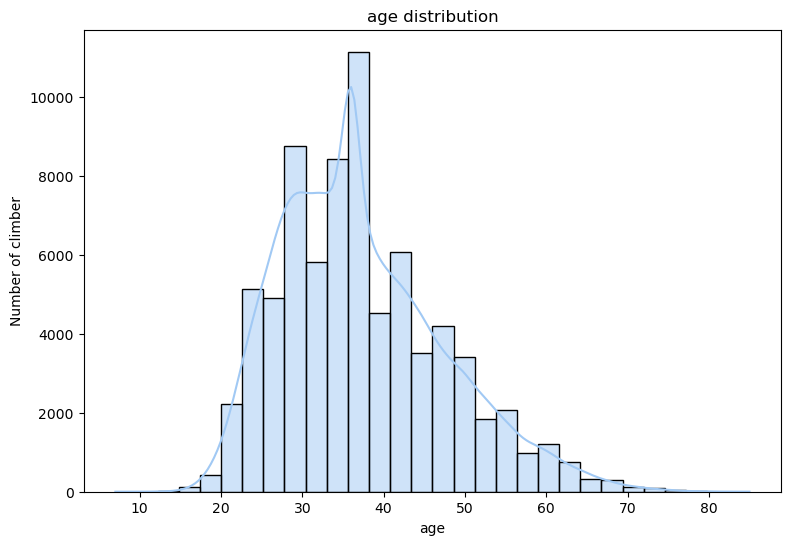

In [67]:
blue_pastel = sns.color_palette("pastel")[0]
plt.figure(figsize=(9, 6))
sns.histplot(data=members_df, x='age', bins=30, kde=True, color=blue_pastel )
plt.title('age distribution')
plt.xlabel('age')
plt.ylabel('Number of climber')
plt.show()

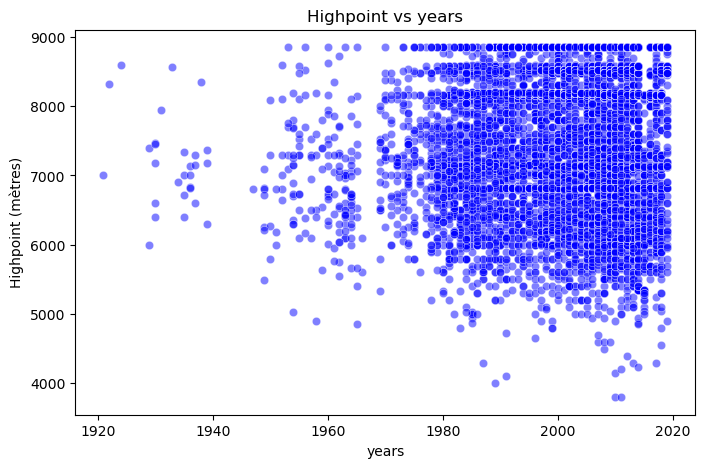

In [68]:
# retravailler 
plt.figure(figsize=(8, 5))
sns.scatterplot(data=expedition_df, y='highpoint_metres', x='year', alpha=0.5, color = "blue")
plt.title('Highpoint vs years')
plt.ylabel('Highpoint (mètres)')
plt.xlabel('years')
plt.show()

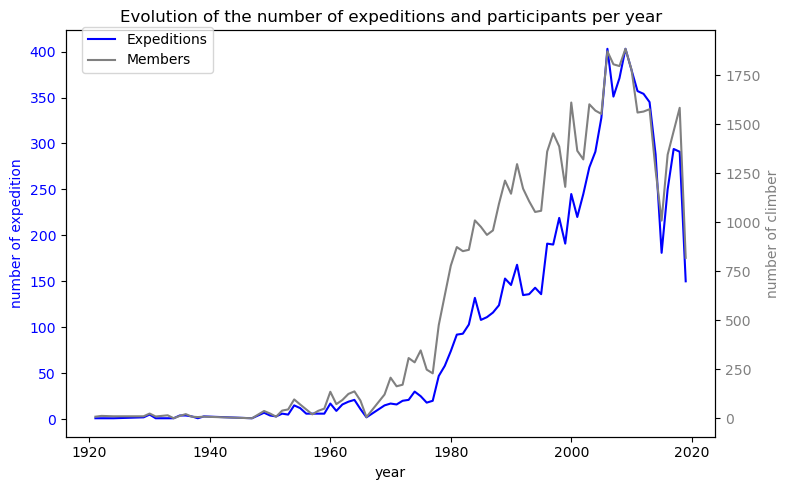

In [69]:
expeditions_per_year = expedition_df.groupby('year').agg({
    'expedition_id': 'count',
    'members': 'sum'
}).reset_index()

expeditions_per_year.columns = ['year', 'num_expeditions', 'num_participants']

# Créer le graphique
fig, ax1 = plt.subplots(figsize=(8, 5))

# Axe pour le nombre d'expéditions
color = 'blue'
ax1.set_xlabel('year')
ax1.set_ylabel('number of expedition', color=color)
ax1.plot(expeditions_per_year['year'], expeditions_per_year['num_expeditions'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Créer un deuxième axe y pour le nombre de participants
ax2 = ax1.twinx()
color = 'grey'
ax2.set_ylabel('number of climber', color=color)
ax2.plot(expeditions_per_year['year'], expeditions_per_year['num_participants'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Titre et légende
plt.title('Evolution of the number of expeditions and participants per year')
fig.tight_layout()
fig.legend(['Expeditions', 'Members'], loc='upper left', bbox_to_anchor=(0.1, 0.95))

plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_18972\710667734.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='season', y='highpoint_metres', data=expedition_df,


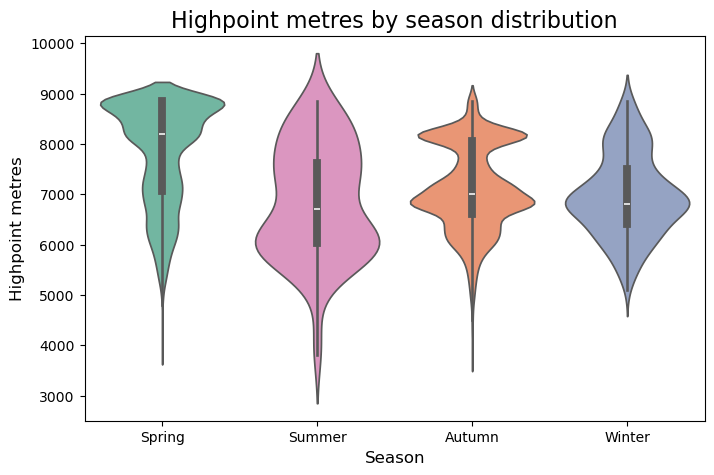

In [70]:
custom_palette = {
    'Spring': '#66c2a5',  # Vert  
    'Summer': '#e78ac3',  # Rose 
    'Autumn': '#fc8d62',  # Orange 
    'Winter': '#8da0cb'   # Bleu 
}

# Créer le graphique
plt.figure(figsize=(8, 5))
sns.violinplot(x='season', y='highpoint_metres', data=expedition_df, 
               palette=custom_palette, order=['Spring', 'Summer', 'Autumn', 'Winter'])

plt.title('Highpoint metres by season distribution', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Highpoint metres', fontsize=12)

plt.show()

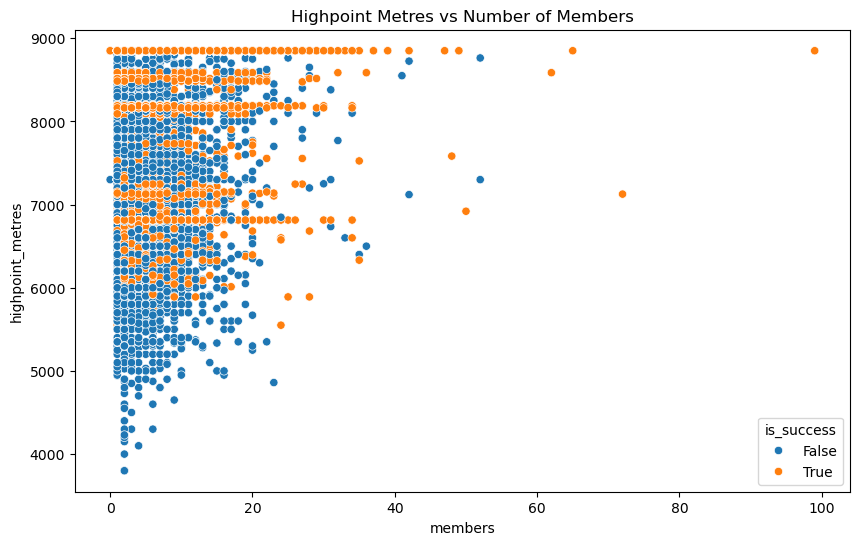

In [71]:
# Scatterplot pour deux variables numériques
plt.figure(figsize=(10, 6))
sns.scatterplot(x='members', y='highpoint_metres', data=expedition_df, hue='is_success')
plt.title('Highpoint Metres vs Number of Members')
plt.show()

### Statistics

In [72]:

numeric_cols = ['highpoint_metres', 'age']
display(members_df[numeric_cols].describe())

numeric_cols2 = ['members', 'hired_staff']
display(expedition_df[numeric_cols2].describe())


,highpoint_metres,age
count,76517.000000,76517.000000
mean,7450.555458,37.273351
std,879.801022,10.159229
min,3800.000000,7.000000
25%,6814.000000,30.000000
50%,7400.000000,36.000000
75%,8167.000000,43.000000
max,8850.000000,85.000000


,members,hired_staff
count,9269.000000,9269.000000
mean,6.108318,2.875823
std,5.396726,5.041777
min,0.000000,0.000000
25%,2.000000,0.000000
50%,5.000000,2.000000
75%,8.000000,3.000000
max,99.000000,99.000000


In [73]:
categorical_cols = ['season', 'peak_name', 'is_success','oxygen_used']
for col in categorical_cols:
    print(f"\nDistribution of {col}:")
    display(expedition_df[col].value_counts(normalize=True))


Distribution of season:


season
Autumn    0.482792
Spring    0.477182
Winter    0.031827
Summer    0.008199
Name: proportion, dtype: float64


Distribution of peak_name:


peak_name
Everest           0.217068
Cho Oyu           0.136261
Ama Dablam        0.125796
Manaslu           0.064085
Lhotse            0.041536
                    ...   
Shalbachum        0.000108
Pharilapcha       0.000108
Chako             0.000108
Ghhanyala Hies    0.000108
Sano Kailash      0.000108
Name: proportion, Length: 365, dtype: float64


Distribution of is_success:


is_success
True     0.553997
False    0.446003
Name: proportion, dtype: float64


Distribution of oxygen_used:


oxygen_used
False    0.697702
True     0.302298
Name: proportion, dtype: float64

In [74]:
# Test du chi-carré pour l'indépendance

contingency_table = pd.crosstab(expedition_df['season'], expedition_df['is_success'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test p-value for correlation between success et season: {p_value}")

contingency_table = pd.crosstab(expedition_df['oxygen_used'], expedition_df['is_success'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test p-value for correlation between success et oxygen: {p_value}")

# We reject the null hypothesis, which means that season and success are most likely correlated
# We reject the null hypothesis, which means that oxygen_used and success are most likely correlated.

Chi-square test p-value for correlation between success et season: 1.740534396928738e-08
Chi-square test p-value for correlation between success et oxygen: 1.1467904824516018e-183


In [75]:
# Two Sample T-test
df_female = members_df[members_df["sex"]=="F"]["highpoint_metres"]
df_male = members_df[members_df["sex"]=="M"]["highpoint_metres"]

#Set the hypothesis

#H0: highpoint male = highpoint female
#H1: highpoint male != highpoint female

#significance level = 0.05

result = st.ttest_ind(df_male,df_female, equal_var=False)

p_value = result.pvalue

if p_value > 0.05:
    print("We are not able to reject the null hypothesis")
else:
    print("We reject the null hypothesis")

We reject the null hypothesis


In [76]:
# Two Sample T-test
df_staff = members_df[members_df["hired"]=="1"]["age"]
df_climber = members_df[members_df["hired"]=="0"]["age"]

#Set the hypothesis

#H0: avg age staff = avg age climber
#H1: avg age climber != avg age climber

#significance level = 0.05

result = st.ttest_ind(df_staff,df_climber, equal_var=False)

p_value = result.pvalue

if p_value > 0.05:
    print("We are not able to reject the null hypothesis")
else:
    print("We reject the null hypothesis")

We reject the null hypothesis


# 9- Machine Learning

In [77]:
#checking null values
print (f'expedition : {expedition_df.isnull().sum()}')
print (f'members : {members_df.isnull().sum()}')
print (f'peaks : {peaks_df.isnull().sum()}')

expedition : expedition_id         0
peak_id               0
peak_name             0
year                  0
season                0
basecamp_date         0
highpoint_date        0
termination_date      0
termination_reason    0
highpoint_metres      0
members               0
member_deaths         0
hired_staff           0
hired_staff_deaths    0
oxygen_used           0
trekking_agency       0
is_success            0
dtype: int64
members : expedition_id           0
member_id               0
peak_id                 0
peak_name               0
year                    0
season                  0
sex                     0
age                     0
citizenship             0
expedition_role         0
hired                   0
highpoint_metres        0
success                 0
solo                    0
oxygen_used             0
died                    0
death_cause             0
death_height_metres     0
injured                 0
injury_type             0
injury_height_metres    0
dtype: int

In [78]:
#drop null value in peaks_df
peaks_df.dropna(subset=['first_ascent_year'], inplace=True)

In [79]:
#Conversion des dates en format datetime
expedition_df['basecamp_date'] = pd.to_datetime(expedition_df['basecamp_date'])
expedition_df['highpoint_date'] = pd.to_datetime(expedition_df['highpoint_date'])
expedition_df['termination_date'] = pd.to_datetime(expedition_df['termination_date'])

# Création de nouvelles variables
expedition_df['expedition_duration'] = (expedition_df['termination_date'] - expedition_df['basecamp_date']).dt.days

# Encodage des saisons
season_encoded = pd.get_dummies(expedition_df['season'], drop_first=False)

# Encodage des genres
sex_encoded = pd.get_dummies(members_df['sex'], drop_first=False)

# Concaténation des nouvelles variables avec expedition_df
new_expedition_df = pd.concat([expedition_df, season_encoded], axis=1)
new_members_df = pd.concat([members_df, sex_encoded], axis=1)

# Colonnes à inclure dans combined_df
new_expedition_df_columns = ['expedition_id', 'peak_id', 'peak_name', 'year', 'season', 'basecamp_date', 'highpoint_date',
                             'termination_date', 'termination_reason', 'expedition_duration', 'Spring', 'Summer', 'Winter','Autumn', 'members','hired_staff']
new_members_columns = ['expedition_id', 'member_id', 'F', 'M', 'age', 'citizenship', 'expedition_role', 'hired', 'highpoint_metres',
                   'success', 'solo', 'oxygen_used', 'died', 'death_cause', 'death_height_metres', 'injured', 'injury_type',
                   'injury_height_metres']
peaks_columns = ['peak_id', 'peak_name', 'height_metres']

# Fusion manuelle des DataFrames en sélectionnant les colonnes spécifiques
combined_df = new_expedition_df[new_expedition_df_columns].merge(new_members_df[new_members_columns], on='expedition_id', how='left')
combined_df = combined_df.merge(peaks_df[peaks_columns], on='peak_id', how='left')

# Affichage des premières lignes du résultat
print(combined_df.head())

  expedition_id peak_id   peak_name_x  year  season basecamp_date  \
0     ANN260101    ANN2  Annapurna II  1960  Spring    1960-03-15   
1     ANN260101    ANN2  Annapurna II  1960  Spring    1960-03-15   
2     ANN260101    ANN2  Annapurna II  1960  Spring    1960-03-15   
3     ANN260101    ANN2  Annapurna II  1960  Spring    1960-03-15   
4     ANN260101    ANN2  Annapurna II  1960  Spring    1960-03-15   

  highpoint_date termination_date   termination_reason  expedition_duration  \
0     1960-05-17       1960-04-10  Success (main peak)                   26   
1     1960-05-17       1960-04-10  Success (main peak)                   26   
2     1960-05-17       1960-04-10  Success (main peak)                   26   
3     1960-05-17       1960-04-10  Success (main peak)                   26   
4     1960-05-17       1960-04-10  Success (main peak)                   26   

   ...   solo  oxygen_used   died  death_cause  death_height_metres  injured  \
0  ...  False        False  Fa

In [80]:
columns_to_keep = ['expedition_id', 'peak_id', 'peak_name_x','height_metres', 'year', 'season',
                   'basecamp_date', 'highpoint_date', 'termination_date',
                   'termination_reason', 'expedition_duration', 'Spring', 'Summer',
                   'Winter', 'Autumn','members','hired_staff','member_id', 'F','M', 'age', 'citizenship', 'expedition_role',
                   'hired', 'highpoint_metres', 'success', 'solo', 'oxygen_used', 'died',
                   'death_cause', 'death_height_metres', 'injured', 'injury_type',
                   'injury_height_metres' ]

combined_df = combined_df[columns_to_keep]

combined_df.head()

,expedition_id,peak_id,peak_name_x,height_metres,year,season,basecamp_date,highpoint_date,termination_date,termination_reason,...,highpoint_metres,success,solo,oxygen_used,died,death_cause,death_height_metres,injured,injury_type,injury_height_metres
0,ANN260101,ANN2,Annapurna II,7937.0,1960,Spring,1960-03-15,1960-05-17,1960-04-10,Success (main peak),...,7400.0,False,False,False,False,0,0.0,False,0,0.0
1,ANN260101,ANN2,Annapurna II,7937.0,1960,Spring,1960-03-15,1960-05-17,1960-04-10,Success (main peak),...,7937.0,True,False,True,False,0,0.0,False,0,0.0
2,ANN260101,ANN2,Annapurna II,7937.0,1960,Spring,1960-03-15,1960-05-17,1960-04-10,Success (main peak),...,7250.0,False,False,False,False,0,0.0,False,0,0.0
3,ANN260101,ANN2,Annapurna II,7937.0,1960,Spring,1960-03-15,1960-05-17,1960-04-10,Success (main peak),...,7250.0,False,False,False,False,0,0.0,False,0,0.0
4,ANN260101,ANN2,Annapurna II,7937.0,1960,Spring,1960-03-15,1960-05-17,1960-04-10,Success (main peak),...,7937.0,True,False,True,False,0,0.0,False,0,0.0


In [81]:
combined_df = combined_df.dropna()
combined_df.shape

(70057, 34)

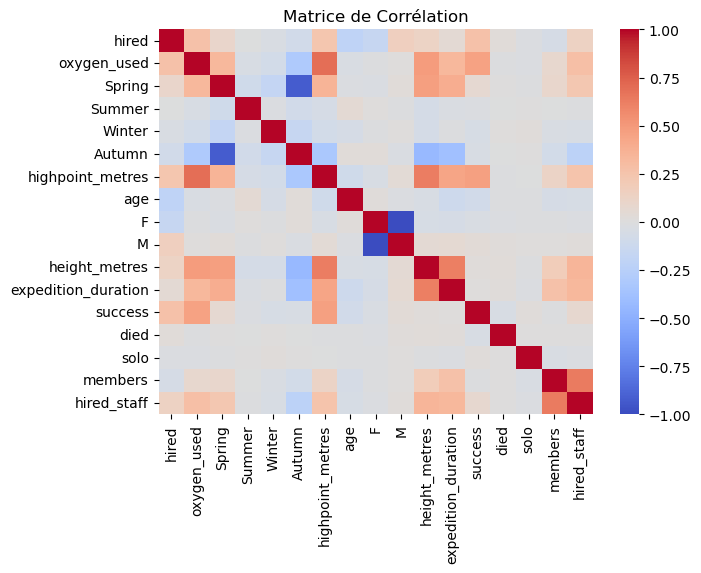

In [82]:
corre = combined_df[['hired', 'oxygen_used', 'Spring', 'Summer', 'Winter','Autumn', 'highpoint_metres', 'age', 'F', 'M', 'height_metres','expedition_duration', 'success','died','solo', 'members','hired_staff']]
correlation_matrix = corre.corr()
# Affichage de la matrice de corrélation
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matrice de Corrélation')
plt.show()

In [83]:
# Sélection des features et de la target
features = combined_df[['hired', 'oxygen_used', 'Spring', 'Summer', 'Winter', 'Autumn', 'age', 'F', 'M', 'height_metres', 'solo', 'members', 'hired_staff', 'expedition_duration']]
target = combined_df['success']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

# Normalisation des données
normalizer = MinMaxScaler()
normalizer.fit(X_train)
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Sauvegarder le normalizer pour l'utiliser dans l'application Streamlit
joblib.dump(normalizer, 'streamlit/scaler.pkl')

# Fonction qui définit le meilleur modèle
def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
    results_df = pd.DataFrame(results)
    return results_df

# Définir des modèles avec différents hyperparamètres
models = {
    'Random Forest (100, 20, 2, 1, auto)': RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1, max_features='auto', random_state=42),
    'Random Forest (150, 25, 5, 2, sqrt)': RandomForestClassifier(n_estimators=150, max_depth=25, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', random_state=42),
    'Random Forest (200, 15, 10, 4, log2)': RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=10, min_samples_leaf=4, max_features='log2', random_state=42),
    'Bagging Classifier': BaggingClassifier(DecisionTreeClassifier(max_depth=20), n_estimators=100, max_samples=1000),
    'Ada Boost': AdaBoostClassifier(DecisionTreeClassifier(max_depth=20), n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(max_depth=20, n_estimators=100)
}

results_df = evaluate_models(models, X_train_norm, X_test_norm, y_train, y_test)
display(results_df)

# Enregistrer le meilleur modèle trouvé
best_model_name = results_df.loc[results_df['Accuracy'].idxmax()]['Model']
best_model = models[best_model_name]
joblib.dump(best_model, 'streamlit/best_random_forest_model.pkl')


c:\Users\User\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


,Model,Accuracy,Precision,Recall,F1 Score
0,"Random Forest (100, 20, 2, 1, auto)",0.810020,0.776420,0.709131,0.741252
1,"Random Forest (150, 25, 5, 2, sqrt)",0.814017,0.778157,0.720848,0.748407
2,"Random Forest (200, 15, 10, 4, log2)",0.793891,0.760301,0.676028,0.715692
3,Bagging Classifier,0.781330,0.742402,0.658732,0.698069
4,Ada Boost,0.784256,0.726259,0.702622,0.714245
5,Gradient Boosting,0.801884,0.745609,0.734238,0.739880


['streamlit/best_random_forest_model.pkl']

In [84]:
X_test.head()

,hired,oxygen_used,Spring,Summer,Winter,Autumn,age,F,M,height_metres,solo,members,hired_staff,expedition_duration
45489,False,False,False,False,False,True,48.0,False,True,8163.0,False,4,2,23
15262,False,False,True,False,False,False,34.0,False,True,8850.0,False,15,0,57
57318,True,True,True,False,False,False,23.0,False,True,8850.0,False,7,4,33
14530,True,False,True,False,False,False,28.0,False,True,8188.0,False,4,5,35
16203,False,False,False,False,False,True,37.0,False,True,7104.0,False,9,2,19


In [85]:
y_pred = best_model.predict(X_test)
y_pred

c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([False, False,  True, ..., False, False,  True])

In [86]:
combined_df.to_csv('csv/combined_df.csv')